## Entity Resolution

## Yoones Vaezi (yooens.vaezi@gmail.com)

First we import some libraries

In [547]:
import pandas as pd
import re
import os
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import spacy
import recordlinkage
from recordlinkage.index import SortedNeighbourhood
from recordlinkage.base import BaseCompareFeature
nlp = spacy.load("en_core_web_lg")

## Read the data

Now we read in the two csv files for entity resolution task:

In [548]:
DBLP = pd.read_csv(r'./data_files/DBLP.csv',encoding = "ISO-8859-1")
Scholar = pd.read_csv(r'./data_files/Scholar.csv',encoding = "ISO-8859-1")

## Explore the data

we first check the number of records in each file:

In [549]:
print(f"DBLP dataframe has {DBLP.shape[0]} records")
print(f"Scholar dataframe has {Scholar.shape[0]} records")

DBLP dataframe has 2616 records
Scholar dataframe has 64260 records


Let's have a look at the first few rows of each dataframe:

In [550]:
DBLP.head(10)

,idDBLP,title,authors,venue,year,row_id
0,conf/vldb/RusinkiewiczKTWM95,Towards a Cooperative Transaction Model - The ...,"M Rusinkiewicz, W Klas, T Tesch, J W_sch, P Muth",VLDB,1995,1
1,journals/sigmod/EisenbergM02,SQL/XML is Making Good Progress,"A Eisenberg, J Melton",SIGMOD Record,2002,2
2,conf/vldb/AmmannJR95,Using Formal Methods to Reason about Semantics...,"P Ammann, S Jajodia, I Ray",VLDB,1995,3
3,journals/sigmod/Liu02,Editor's Notes,L Liu,SIGMOD Record,2002,4
4,journals/sigmod/Hammer02,Report on the ACM Fourth International Worksho...,NaN,NaN,2002,5
5,conf/vldb/FerrandinaMZFM95,Schema and Database Evolution in the O2 Object...,"F Ferrandina, T Meyer, R Zicari, G Ferran, J M...",VLDB,1995,6
6,conf/vldb/SubietaKL95,Procedures in Object-Oriented Query Languages,"K Subieta, Y Kambayashi, J Leszczylowski",VLDB,1995,7
7,journals/sigmod/BargaL02,Phoenix Project: Fault-Tolerant Applications,"R Barga, D Lomet",SIGMOD Record,2002,8
8,journals/sigmod/Ouksel02,Mining the World Wide Web: An Information Sear...,NaN,NaN,2002,9
9,conf/vldb/MoserKK95,L/MRP: A Buffer Management Strategy for Intera...,"F Moser, A Kraiss, W Klas",VLDB,1995,10


In [551]:
Scholar.head(10)

,idScholar,title,authors,venue,year,row_id
0,aKcZKwvwbQwJ,11578 Sorrento Valley Road,QD Inc,"San Diego,",NaN,1
1,ixKfiTHoaDoJ,Initiation of crazes in polystyrene,"AS Argon, JG Hannoosh","Phil. Mag,",NaN,2
2,3BxllB4wwcIJ,Immunogold labelling is a quantitative method ...,"GH Hansen, LL Wetterberg, H SjÍ_strÍ_m, O ...","The Histochemical Journal,",1992.0,3
3,d2WWxwKMex4J,The Burden of Infectious Disease Among Inmates...,"TM Hammett, P Harmon, W Rhodes",see,NaN,4
4,cZCX-AQpjccJ,The Role of Faculty Advising in Science and En...,JR Cogdell,"NEW DIRECTIONS FOR TEACHING AND LEARNING,",1995.0,5
5,DMhfVNSDYD4J,The zero multiplicity of linear recurrence seq...,WM Schmidt,to,NaN,6
6,97wRWOpnANkJ,PREDICITVE VALIDITY OF KINDERGARTEN SCREENERS ...,RA Haats,NaN,2002.0,7
7,xSv97kdDZU8J,The Photosynthetic Reaction Center,"JR Norris, J Deisenhofer","San Diego: Academic,",NaN,8
8,vj0-A5RoktIJ,"F., Diene, AW, Ndiaye, Y. Hachage linÍ©aire ...",F Bennour,"Res. Rep. CERIA, U. Paris,",NaN,9
9,6TKMB5gO9EoJ,Multidimensional similarity structure analysis,"I Borg, JC Lingoes",NaN,1987.0,10


There seems to exist some NaN values in both dataframes. Let's first check how many of them we have in each:

In [552]:
print('Number of NaN values in each column of DBLP dataframe: ')
DBLP.isnull().sum(axis = 0)

Number of NaN values in each column of DBLP dataframe: 


idDBLP       0
title        0
authors    218
venue      211
year         0
row_id       0
dtype: int64

In [553]:
print('Number of NaN values in each column of Scholar dataframe: ')
Scholar.isnull().sum(axis = 0)

Number of NaN values in each column of Scholar dataframe: 


idScholar        0
title            0
authors          1
venue        14997
year         34789
row_id           0
dtype: int64

There seems to not exiast any NaN values for the identifier, title, and row_id in both files. Almost 8% of the records do not have an author name and venue name in the DBLP data. Even though Scholar data has only one missing authors name, it however, misses 23% of the venue information and 54% of the year column. 
* This means that the title column should be the main refernece point for matching these two dataframes. This makes sense, as two publications that are deemed the same should have high degree of similarity in their titles, with minor differences. 
* Even though some of the entries for the author column are missing in the DBLP data, this column seems to be consistent among the two data in terms of its template (first name initial, last name). Therefore, we can use this as a second referenvce point for comparison when it exists in both data.
* The year column (as shown below) in the Scholar data seems to suffer from a lot of mistakes and is also missing in 23% of the times. Therefore it is not here considered as a criteria for comparison here. 
* There is a lot of missing values for the venue column of Scholar data. Also some are missing in the DBLP data. However, we can use this column as another matching criteria when they exist in both data. 

The columns "idDBLP" and "idScholar" are the unique publication identifiers. We need to ensure there is no duplicated identifiers for each dataframe and these identifiers are meaningful. For this, we ensure there is no empty, NAN values, and duplicates in the id columns. We have already seen that there are no NaN values in the identifiers. Let's check the duplicates:

In [554]:
duplicateIds_DBLP = DBLP[DBLP.duplicated(['idDBLP'])]
duplicateIds_DBLP['idDBLP']

Series([], Name: idDBLP, dtype: object)

In [555]:
duplicateIds_Scholar = Scholar[Scholar.duplicated(['idScholar'])]
duplicateIds_Scholar['idScholar']

463       
553       
613       
744       
873       
        ..
63668     
63893     
64021     
64081     
64164     
Name: idScholar, Length: 762, dtype: object

There are 752 rows in Scholar dataset that have no unique identifiers. To ensure there is no records with missing identifier, we drop (remove) such records from both datasets.

In [556]:
def removeBadIds(df,id_cols):
    ''' Removes the rows where publication identifier is missing
    df: input data frame
    id_col: the column name list 
    
    output
    dataframe with no missing identifiers'''
    df1= df.copy()
    for icol in id_cols:
        df1[icol] = df1[icol].replace(r'^\s*$', np.nan, regex=True)
        df1 = (df1.dropna(subset=[icol]))
    return df1

In [557]:
DBLP = removeBadIds(DBLP,['idDBLP'])
Scholar = removeBadIds(Scholar,['idScholar'])

Let's ensure this has removed the non-unique empty identifiers.

In [558]:
Scholar[Scholar.duplicated(['idScholar'])]['idScholar']

Series([], Name: idScholar, dtype: object)

Great! there is no recors with missing identifier in the data now.

Let's also explore the year column in both datasets: 

Text(0.5, 1.0, 'publiction year for DBLP')

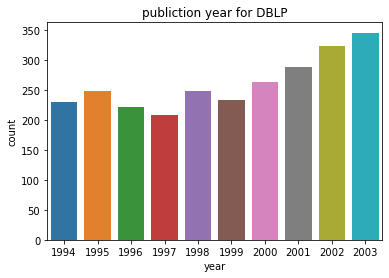

In [559]:
ax = sns.countplot(x="year", data=DBLP)
ax.set_title('publiction year for DBLP')

The DBLP data contains 10 unique publication years, from 1994 through 2003. We assume that these values are valid.

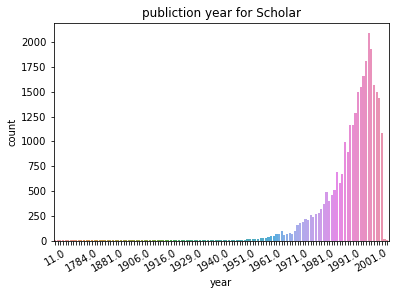

In [560]:
ax = sns.countplot(x="year", data=Scholar)
ax.set_title('publiction year for Scholar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [561]:
print(Scholar['year'].min(),Scholar['year'].max())

11.0 2730.0


Text(0, 0.5, 'year')

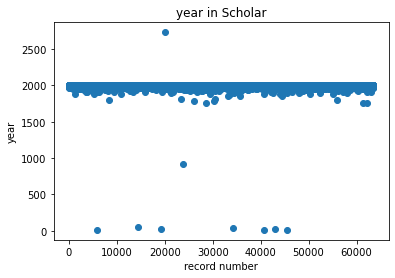

In [562]:
plt.scatter(range(Scholar.year.shape[0]),Scholar.year)
plt.title('year in Scholar')
plt.xlabel('record number')
plt.ylabel('year')

There are anomalously small and large values in the publication year of Scholar dataset. We assume that any value above 2021 and below 1750 are invalid and we set them to NaN.

Text(0.5, 0, 'year in Scholar')

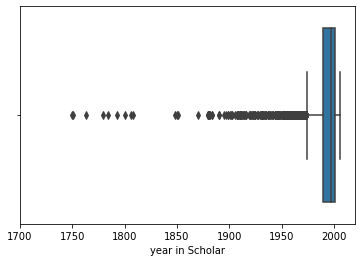

In [563]:
ax = sns.boxplot(x=Scholar["year"])
ax.set_xlim([1700,2020])
plt.xlabel('year in Scholar')

In [564]:
def cleanYear(df,year_col,min_val,max_val):
    ''' Replaces invalid publication years to np.nan
    df: input data frame
    year_col: the column name for the publication year
    min_val,max_val: min and max allowable publication year
    
    output
    dataframe with publication years outside the allowable range set to np.nan'''
    df1 = df.copy()
    df1.loc[(df1[year_col]<min_val) | (df1[year_col]>max_val),year_col]=np.nan
    return df1

In [565]:
DBLP = cleanYear(DBLP,'year',1750,2021)
Scholar = cleanYear(Scholar,'year',1750,2021)

In [566]:
print(Scholar['year'].min(),Scholar['year'].max())

1750.0 2006.0


Now the publication year for the Scholars data ranges between 1750 to 2006. 

Let's check the data types in the two data sets ensuring they are consistent:


In [567]:
DBLP.dtypes

idDBLP      object
title       object
authors     object
venue       object
year       float64
row_id       int64
dtype: object

In [568]:
Scholar.dtypes

idScholar     object
title         object
authors       object
venue         object
year         float64
row_id         int64
dtype: object

They seem to match. Great!

Let's also check the venue columns in the two datasets. 

In [569]:
DBLP['venue'].value_counts()

VLDB                         861
SIGMOD Conference            771
SIGMOD Record                449
VLDB J.                      191
ACM Trans. Database Syst.    132
ecord                          1
Name: venue, dtype: int64

In [570]:
Scholar['venue'].value_counts()

LECTURE NOTES IN COMPUTER SCIENCE,                                    957
Cochrane Database Syst Rev,                                           902
New Directions for Higher Education,                                  885
Phil. Mag,                                                            817
Computer Networks,                                                    789
                                                                     ... 
Proc. ACM SIGMOD, Portland                                              1
&hellip;  of the 1985 VLDB Conference, Stockholm. Sweden, August,       1
ACM TOG,                                                                1
Proc. 29th Annual Allerton Conference on Communication,  &hellip;,      1
Proceedings of the 1998 ACM-SIGMOD International Conference             1
Name: venue, Length: 12428, dtype: int64

There seems to be only 6 unique types of venues in DBLP dataset, while, there are 12428 unique venues in the Scolar dataset. The DBLP venues seem to be listed in an abbreviated way while Scholar venues are listed in a longer version. Even though there are a lot of venues missing from both datsets, the string (substring) matching can be used to match up records in the two datasets, when both are valid (not NaN).
Both of these columns, specially in Scholar dataset, require text cleaning, which is explained below.

## Text cleaning

As the title and author columns (and also (venue) are the main features for matching criteria and they are string features, we now focus on cleaning these columns in the two datasets. Text cleaning for these columns includes:
* removing heading and trailing spaces/tabs 
* removing special characters and keeping only alphanumeric strings
* replacing & with 'and' and replacing multiple spaces/tabs with one space 
* removing stopwords
* removing punctuations
* Removing pronouns for reducing their dominance on word embeddings
* lemmetizing tokens to reduce them to their base form

The Spacy library is used for vectorizing sentences and tokens. We use the "en_core_web_lg" trained pipelines for English in Spacy to vectorize tokens.

In [572]:
def text_cleaner(text):
    ''' Given a text, returns cleaned version of it by lowercasing it, removing special characters, 
    stopwords, pronouns, and spaces
    text: input text
        
    output
    cleaned text'''
    text = str(text)
    # Removing spaces and bad symbols and converting text into lowercase
    text = text.strip().lower() 
    # remove special characters
    REPLACE_BY_SPACE_RE = re.compile('[()\\\\{/}\[\]\|@,:;\-<>_.\'\"?!#$%^"~+`]')
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # keeping alphanumeric entries only
    BAD_SYMBOLS_RE = re.compile('[^\w\s]')
    text = BAD_SYMBOLS_RE.sub('', text) 
    # replacing & with and
    text = re.sub('&', ' and ', text)
    #replace 
    text = re.sub('\s+',' ',text)
    text = text.strip()
    # use Spacy trained pipeline to vectorize tokens and use them to remove stop words, pronouns, and also lemmatize
    doc = nlp(text)
    result = []
    for token in doc:
        if token.text in nlp.Defaults.stop_words:
            continue
        if token.is_punct:
            continue
        if token.lemma_ == '-PRON-':
            continue
        result.append(str(token.lemma_).strip())
    out = " ".join(result)
    out = re.sub('\s+',' ',out) 
    if out=='' or out==' ':
        out = np.nan
    return out

Now let's use this function to clean up the string columns of interest:

In [573]:
def cleanTextInDF(df,column_list):
    ''' Cleans given string columns of a dataframe using the text_cleaner function
    df: input data frame
    column_list: list of string columns to clean
        
    output
    dataframe with cleaned columns with _cleaneded to their names'''
    df1 = df.copy()
    for aCol in column_list:
        new_col_name = aCol+'_cleaned'
        df1[new_col_name] = df1[aCol].apply(lambda x:text_cleaner(x))
    return df1

In [574]:
DBLP_cleaned = cleanTextInDF(DBLP,['title','authors','venue'])
Scholar_cleaned = cleanTextInDF(Scholar,['title','authors','venue'])

Now let's see an example of how the string columns look like after cleaning. Below we are shoiwng a random string cell in the Scholar dataset before and after cleaning. The cleaning is doingh a great job of what is intended for:

In [575]:
print(f"String before cleaning: {Scholar.loc[300,'title']}")
print(f"String after cleaning: {Scholar_cleaned.loc[300,'title_cleaned']}")

String before cleaning: A University-Industry Association Model for Curriculum Enhancement.
String after cleaning: university industry association model curriculum enhancement


## Record linkage 

Now that we have cleaned the datasets, we proceed with data matching. We divide this two three different steps:

* Blocking (indexing) stage
* Comparison stage
* Matching stage

The indexing module is used to make pairs of records. These pairs are called candidate links or candidate matches. Note that by blocking we mean to block a tuple pair from going through to the comparison step. When applied to a tuple pair, a blocker returns True if the pair should be blocked. There are several indexing algorithms available such as blocking and sorted neighborhood indexing. We use the sorted neighborhood indexing approach provided in the Python Record Linkage Toolkit: https://recordlinkage.readthedocs.io/en/latest/index.html. According to its tutorial: "This algorithm returns record pairs that agree on the sorting key, but also records pairs in their neighbourhood. A large window size results in more record pairs. A window size of 1 returns the blocking index. The Sorted Neighbourhood Index method is a great method when there is relatively large amount of spelling mistakes. Blocking will fail in that situation because it excludes to many records on minor spelling mistakes." 

In the comparison stage, a set of informative, discriminating and independent features is important for a good classification of record pairs into matching and distinct pairs. In Python Record Linkage Toolkit, recordlinkage.Compare class and its methods can be used to compare records pairs. Several comparison methods are included such as string similarity measures, numerical measures and distance measures. Here we only use the framework of this library to define blocking but generally define our own comparison classes. We only use the "numeric" comparison capability of the Compare class of this toolkit. 

Finally, in the matching stage, once we have defined and run the comparison part, we set thresholds on the calculated comparison features to classify the records into matchin and non-matching classes. 

### 1- Blocking stage: Obtain candidate links

One way to perform comparison and matching is to compare every single record pair in the two datasets. But this will result in a large amount of unnecessary calculation if there are too many clearly unmatching pairs. Therefore instead of considering all combination of recors (full blocking), we use the fact the fact that the title and author name of the articles are going to be two important features for deciding whether two entries are the same. Therefore, we decided to use the sorted neighborhood indexing approach in the Python Record Linkage Toolkit to limit the amount of candidate pairs for linking. 

First, we set the publication identifier as the index of the datasets:

In [576]:
DBLP_cleaned_reindexed = DBLP_cleaned.set_index('idDBLP')
Scholar_cleaned_reindexed = Scholar_cleaned.set_index('idScholar')

We now calculate candidate links by indexing (blocking) pairs via performed using cleansed title and author fields:

In [577]:
def createCandidateLinks(df1,df2,window=3):
    ''' Creates candidate links using blocking (sorted neighbourhood approach) 
    df1 and df2: input data frames
    window: window size
        
    output:
    candidate link tuple pairs'''
    indexer = recordlinkage.Index()
    indexer.add(SortedNeighbourhood(left_on='title_cleaned', right_on='title_cleaned', window=window))
    indexer.add(SortedNeighbourhood(left_on='authors_cleaned', right_on='authors_cleaned', window=window))
    candidate_links = indexer.index(df1, df2)
    return candidate_links

In [578]:
candidate_links = createCandidateLinks(DBLP_cleaned_reindexed,Scholar_cleaned_reindexed,window=3)
print(len(candidate_links))

16945


In [579]:
DBLP_cleaned_reindexed.shape[0]*Scholar_cleaned_reindexed.shape[0]

166108152

Using the blocking method, we have reduced the number of possible candidates from 166108152 (the product of record sizes of the two datasets) to only 16945. This is going to greatly speed up the comparison stage. 

### 2- Comparison stage

For the comparison stage we mainly use custom comparison classes we have defined. Below is the list of classes we are using for comparison stage:

* GetSimilarity: This class is used for comparing cleaned string features including title, authors, and venue using cosine similarity between the embedding vectors of the the strings in the cleaned columns of the two datasets.
* GetYearSimilarity: This class is used for comparing year features. An exact match is evaluated between the two year columns.

In [580]:
class GetSimilarity(BaseCompareFeature):
    def _compute_vectorized(self, s1, s2):
        """calculate string similarity using Spacy trained pipelines.
        Similarity ranges from 0 to 1. 
        """
        s1_new = s1.apply(lambda x:nlp(x) if not pd.isnull(x) else np.nan)
        s2_new = s2.apply(lambda x:nlp(x) if not pd.isnull(x) else np.nan)
        both_ = (pd.concat([s1_new, s2_new], axis=1)).apply(lambda x:x[0].similarity(x[1]) if (not pd.isnull(x[0]) and not pd.isnull(x[1])) else np.nan,axis=1)
        return both_

In [581]:
class GetYearSimilarity(BaseCompareFeature):
    def _compute_vectorized(self, s1, s2):
        """Compare publication years.
        If the years in both records are identical, the similarity
        is 1. Otherwise, the similarity is 0.
        """
        sim = s1.copy()
        for i in range(s1.shape[0]):
            if not pd.isnull(s1[i]) and not pd.isnull(s2[i]) and s1[i]==s2[i]:
                sim[i] = 1.0
            elif not pd.isnull(s1[i]) and not pd.isnull(s2[i]) and s1[i]!=s2[i]:
                sim[i] = 0.0
            else:
                sim[i] = np.nan

        return sim

Now we use these cusrtom classes to perform the comparison stage:

In [582]:
def getComparisonFeatures(df1,df2,candidate_links):
    """calculate comparison features for candidate links.
     df1 and df2: input data frames
    candidate_links: candidate links from blocking stage
        
    output:
    features: multi-indexed comparison features
        """
    compare_cl = recordlinkage.Compare()
    compare_cl.add(GetSimilarity('title_cleaned', 'title_cleaned', label='titleSim'))
    compare_cl.add(GetSimilarity('authors_cleaned', 'authors_cleaned', label='authorSim'))
    compare_cl.add(GetSimilarity('venue_cleaned', 'venue_cleaned', label='venueSim'))
    compare_cl.add(GetYearSimilarity('year', 'year', label='yearSim'))
    features = compare_cl.compute(candidate_links, df1, df2)
    return features

In [583]:
features = getComparisonFeatures(DBLP_cleaned_reindexed,Scholar_cleaned_reindexed,candidate_links)

<ipython-input-580-3dc1e63246ef>:8: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  both_ = (pd.concat([s1_new, s2_new], axis=1)).apply(lambda x:x[0].similarity(x[1]) if (not pd.isnull(x[0]) and not pd.isnull(x[1])) else np.nan,axis=1)


Let's see what the calculated comparison features look like:

In [584]:
features.head(30)

titleSim  authorSim  \
idDBLP                             idScholar                           
conf/sigmod/2000                   IG6ny5f3oqkJ  0.496519   0.217775   
                                   PbPCf78sARsJ  0.440638   0.253300   
                                   jqQgs11omKsJ  0.749702   0.450312   
                                   yjssHUb2BqYJ  0.356557   1.000000   
conf/sigmod/2002                   IG6ny5f3oqkJ  0.517286   0.217775   
                                   PbPCf78sARsJ  0.459474   0.253300   
                                   yjssHUb2BqYJ  0.364165   1.000000   
conf/sigmod/2003                   A5xyn_tC6_wJ  0.406219   0.271913   
                                   IG6ny5f3oqkJ  0.491608   0.217775   
                                   PbPCf78sARsJ  0.451823   0.253300   
                                   yjssHUb2BqYJ  0.349429   1.000000   
conf/sigmod/AbadiC02               08ezT21wynYJ  0.425210   0.556822   
                                   B03NxiJHIlMJ  0.594384   0.535330   
                                   f2Lea-RN8dsJ  1.000000   0.549529   
                                   ff5EyPXrJ90J  0.557290   0.364949   
conf/sigmod/AbadiCCCCEGHMRSSTXYZ03 3rBlVqEbkbcJ  0.206419   0.791826   
                                   VuY9Y49GqXgJ  1.000000   0.891649   
                                   eBnT7lhV2LwJ  0.954886   0.912384   
conf/sigmod/AbiteboulBCMM03        AWT9oagMfNMJ  0.564136   0.476290   
                                   AxpQwgyRyLgJ  0.960545   0.916024   
                                   OJ7dAFJgnwgJ  0.489361   0.371760   
                                   Rjb06zlxbLIJ  1.000000   0.916024   
                                   S1rzR4Imj8EJ  0.533770   0.476290   
                                   VJVukBz-cOMJ  0.345765   0.476290   
                                   WXXoydxzOOMJ  0.332502   0.476290   
                                   iz8I017svR8J  0.717178   0.745588   
conf/sigmod/AbiteboulCM95          18_r28t9ICYJ  0.413000   0.737718   
                                   4GT0Krd9RP0J  0.872527   1.000000   
                                   DakOA4Ew-poJ  0.977388   1.000000   
                                   N14PBymOIIQJ  0.569396   0.825177   

                                                 venueSim  yearSim  
idDBLP                             idScholar                        
conf/sigmod/2000                   IG6ny5f3oqkJ  0.056868      0.0  
                                   PbPCf78sARsJ  1.000000      NaN  
                                   jqQgs11omKsJ  0.203323      NaN  
                                   yjssHUb2BqYJ  1.000000      NaN  
conf/sigmod/2002                   IG6ny5f3oqkJ  0.056868      0.0  
                                   PbPCf78sARsJ  1.000000      NaN  
                                   yjssHUb2BqYJ  1.000000      NaN  
conf/sigmod/2003                   A5xyn_tC6_wJ  0.045702      NaN  
                                   IG6ny5f3oqkJ  0.056868      0.0  
                                   PbPCf78sARsJ  1.000000      NaN  
                                   yjssHUb2BqYJ  1.000000      NaN  
conf/sigmod/AbadiC02               08ezT21wynYJ  0.761262      NaN  
                                   B03NxiJHIlMJ -0.028281      NaN  
                                   f2Lea-RN8dsJ  1.000000      1.0  
                                   ff5EyPXrJ90J -0.028281      0.0  
conf/sigmod/AbadiCCCCEGHMRSSTXYZ03 3rBlVqEbkbcJ  0.149770      0.0  
                                   VuY9Y49GqXgJ -0.028281      NaN  
                                   eBnT7lhV2LwJ  0.685459      NaN  
conf/sigmod/AbiteboulBCMM03        AWT9oagMfNMJ -0.028281      0.0  
                                   AxpQwgyRyLgJ  0.175593      NaN  
                                   OJ7dAFJgnwgJ -0.028281      NaN  
                                   Rjb06zlxbLIJ  1.000000      1.0  
                                   S1rzR4Imj8EJ  0.651813      NaN  
                   

### 3- Matching stage

Finally using the calculated features we try to find the rows that represent matching records. There are many ways to threshold the combined set of features calculated to find matches. Here we only do a simple one where we seach for rows where title similarity is above 0.8 and the author similarity and venue similarity are above 0.6. 

In [585]:
result = features[(features['titleSim']>0.8) & (features['authorSim']>0.6) & (features['yearSim']>0.6)]
result.head()

,,titleSim,authorSim,venueSim,yearSim
idDBLP,idScholar,,,,
conf/sigmod/AbiteboulBCMM03,Rjb06zlxbLIJ,1.000000,0.916024,1.000000,1.0
conf/sigmod/AbiteboulCM95,cu9DXtjeF24J,0.945408,1.000000,0.694555,1.0
conf/sigmod/AboulnagaC99,WWaxLMIptTMJ,1.000000,1.000000,1.000000,1.0
conf/sigmod/AcharyaAFZ95,rO4-yA3tlfoJ,1.000000,1.000000,1.000000,1.0
conf/sigmod/AcharyaFZ97,9OEjtHuRUzsJ,1.000000,1.000000,1.000000,1.0


In [586]:
result_reset = result.reset_index(level=['idDBLP','idScholar'])
result_reset = result_reset.loc[resul_rest.groupby(["idDBLP"])["titleSim"].idxmax()] 
result_reset = result_reset.reset_index(drop=True)
result_reset = result_reset.loc[result_reset.groupby(["idScholar"])["titleSim"].idxmax()] 
out1 = result_reset.merge(DBLP_cleaned)
out1 = out1[['idDBLP','idScholar','row_id']]
out1.rename(columns={'row_id':'DBLP_Match'},inplace=True)
out2 = out1.merge(Scholar_cleaned)
out2 = out2[['idDBLP','idScholar','DBLP_Match','row_id']]
out2.rename(columns={'row_id':'Scholar_Match'},inplace=True)
out2['Match_ID'] = out2[['DBLP_Match','Scholar_Match']].astype(str).apply('_'.join, 1)
out2.head()

,idDBLP,idScholar,DBLP_Match,Scholar_Match,Match_ID
0,conf/sigmod/PengC03,-2JURbcl_AwJ,364,32176,364_32176
1,conf/vldb/AcharyaGP99,-7tsGpHin24J,1459,45718,1459_45718
2,conf/vldb/AmsalegFG95,-9bXTTM_M4cJ,1923,13600,1923_13600
3,conf/vldb/UrhanF01,0-FUXURm1FQJ,1104,48584,1104_48584
4,conf/vldb/SrivastavaDJL96,01ZVDudF4WAJ,1801,28537,1801_28537


Now we save the result as a csv file named DBLP_Scholar_perfectMapping_YoonesVaezi.csv in a directory called outDir.

In [587]:
outDir = './outDir'
if not os.path.exists(outDir):
    os.makedirs(outDir)
out2.to_csv(os.path.join(outDir,'DBLP_Scholar_perfectMapping_YoonesVaezi.csv'),index=False)

In [588]:
len(out2['idScholar'].unique())

1814

So there are 1814 unique matching rows between the two datasets. Done!